In [85]:
%matplotlib inline
import numpy as np
import os
import glob
import shutil
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata as sp_gd
import json
import subprocess
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from IPython.display import Image

# Lab 8: Buckling behavior under compression and shear

Module for computations

In [86]:
import FEM_utilities as FEM

## Write input file

Set parameters for simulation:

- *a*, *b*, *h*: geometry of plate
- **nx**, **ny**, number of elements in *x* and *y* directions
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**) 
- $\gamma$: scale factor of $\tau$ wrt $\sigma$
- *num_modes*: buckling modes to be computed (by default **1**)
- *num_vects* number of vectors to be used (default 8: Abaqus default is min(n+8, $2\cdot n$) )
- *max_iter*: max number of iterations (default 200: Abaqus default is 30)

Function *write_inp_file* defines:

- *filename* : name of input file
- *eltype* : type of shell element (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeUsbHtml/pt06ch29s06alm17.htm))
- *matname*: name of material
- *elname*: **\*Elset** assigned name
- *bc*, *load*: names for boundary condition, external and internal nodes loaded 
- *pa*, *pb*,*ax*, $\alpha$: coordinate points, axis and angle used to define local coordinate system (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeKeyHtml/ch15abk01.htm#usb-kws-morientation)) 
- *intpoints*: shell integration points

In [87]:
def write_inp_file(a, b, h, nx, ny, E, ν, γ, num_modes=1, num_vects=8, max_iter=200):
    """
    function to write inp file:
    a        : lenght of plate
    b        : height
    h        : thickness
    nx       : number of elements in x direction
    ny       : number of elements in y direction
    E        : Young's modulus
    nu       : Poisson ratio
    gamma    : tau = gamma*sigma
    num_modes: number of eigenvalues to be estimated
    num_vects: number of vectors used to estimate eigenvalues (default would be 2)
    max_iter : max number of iterations (default would be 30, we set to 60)
    """
    
    elname = "EALL"
    matname = "mat1"
    
    
    bcs = ["x0_nodes", "xA_nodes", "y0_nodes", "yB_nodes", "fixed"]
    
    sx1_ext = 'sx_0_ext'
    sx1_int = 'sx_0_int'
    sx2_ext = 'sx_a_ext'
    sx2_int = 'sx_a_int'

    txy1_ext = 'txy_0_ext'
    txy1_int = 'txy_0_int'
    tyx1_ext = 'tyx_0_ext'
    tyx1_int = 'tyx_0_int'
    txy2_ext = 'txy_b_ext'
    txy2_int = 'txy_b_int'
    tyx2_ext = 'tyx_a_ext'
    tyx2_int = 'tyx_a_int'
    
    sigma = [sx1_ext, sx1_int, sx2_ext, sx2_int]
    
    tau = [txy1_ext, txy1_int, tyx1_ext, tyx1_int, txy2_ext, txy2_int, tyx2_ext, tyx2_int]
    
    pa = [1.0,0.0,0.0]
    pb = [0.0,1.0,0.0]
    # pc = [0.0,0.0,0.0]
    ax = 3
    α = 0.0
    
    intpoints = 5
    
    basename = 'cs_a'+str(int(a/100)).zfill(2)+'_nx'+str(nx).zfill(3)+'_ny'+str(ny).zfill(3)+\
    '_g'+str(int(γ*100)).zfill(3)

    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    outfile.write("** Lab 08 input file - buckling of plate under compression and shear\n")
        
    nodes, elements, y0, yB, x0, xA = FEM.NodesLab07(nx, ny, a, b)
    
    bc_nodes = [y0, yB, x0, xA, [1]]
    
    # external and internal nodes for loads
    sigma_nodes =[ [y0[0],y0[-1]], y0[1:-1], [yB[0],yB[-1]], yB[1:-1] ]

    
    tau_nodes = [ [y0[0],y0[-1]], y0[1:-1], [x0[0],x0[-1]], x0[1:-1], \
                  [yB[0],yB[-1]], yB[1:-1], [xA[0],xA[-1]], xA[1:-1] ]
        
    # NODES section
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE, nset = nglobal\n")

    for i in range(nodes.shape[0]):
        nodestring = "{0:4d}".format(int(nodes[i,0]))
        for j in range(1,nodes.shape[1]):
            nodestring+=",{0:8}".format(nodes[i,j])
        nodestring+="\n"
        outfile.write(nodestring)
        
    # ELEMENTS section
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, type = S4R\n")
    
    for i in range(elements.shape[0]):
        elstring = "{0:4d}".format(int(elements[i,0]))
        for j in range(1,elements.shape[1]):
            elstring+=",{0:4d}".format(int(elements[i,j]))
        elstring+="\n"
        outfile.write(elstring)

    # MATERIAL section
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*Elastic\n")
    outfile.write("{0},{1:6}\n".format(E,ν))

    # SETS section
    # NODES
    outfile.write("**\n")
    outfile.write("** Sets\n")
    outfile.write("**\n")
    
    for i, bc in enumerate(bcs[:-1]):
        outfile.write("*NSET, nset = {0}\n".format(bc))
        
        n_lines = np.ceil(len(bc_nodes[i])/16)
        
        for i_line in range(int(n_lines)):
            bc_str = "{0:4d}".format(int(bc_nodes[i][16*i_line]))
            
            for j in range(16*i_line+1,min(len(bc_nodes[i]),16*(i_line+1)) ):
                bc_str+=",{0:4d}".format(int(bc_nodes[i][j]))
            bc_str+="\n"
            outfile.write(bc_str)
    
    # loaded
    
    # SIGMA
    for i, s_act in enumerate(sigma):
        if i%2 == 0:
            #external
            outfile.write("*Nset, nset = {0}\n".format(s_act))
            el_str = "{0:4d},{1:4d}\n".format(int(sigma_nodes[i][0]),int(sigma_nodes[i][-1]))
            outfile.write(el_str)
        else:
            # internal
            outfile.write("*Nset, nset = {0}\n".format(s_act))
            
            n_lines = np.ceil(len(sigma_nodes[i])/16)
            
            for i_line in range(int(n_lines)):
                il_str = "{0:4d}".format(int(sigma_nodes[i][16*i_line]))
                for j in range(16*i_line+1,min(len(sigma_nodes[i]),16*(i_line+1)) ):
                    il_str+=",{0:4d}".format(int(sigma_nodes[i][j]))
                il_str+="\n"
                outfile.write(il_str)
            
    # tau
    
    for i, t_act in enumerate(tau):
        if i%2 == 0:
            # external
            outfile.write("*Nset, nset = {0}\n".format(t_act))
            el_str = "{0:4d},{1:4d}\n".format(int(tau_nodes[i][0]),int(tau_nodes[i][-1]))
            outfile.write(el_str)
        else:
            # internal
            outfile.write("*Nset, nset = {0}\n".format(t_act))
            
            n_lines = np.ceil(len(tau_nodes[i])/16)
            
            for i_line in range(int(n_lines)):
                il_str = "{0:4d}".format(int(tau_nodes[i][16*i_line]))
                for j in range(16*i_line+1,min(len(tau_nodes[i]),16*(i_line+1)) ):
                    il_str+=",{0:4d}".format(int(tau_nodes[i][j]))
                il_str+="\n"
                outfile.write(il_str)
    
    
    # ELEMENTS
    outfile.write("*Elset, elset = {0}, generate\n".format(elname))
    outfile.write("{0:4d},{1:4d},{2:4d}\n".format(1,elements.shape[0],1))
    
    # ORIENTATION
    outfile.write("**\n")
    outfile.write("** LOCAL ORIENTATION\n")
    outfile.write("**\n")
    outfile.write("*orientation, name = local_orientation\n")
    outfile.write("".join(str(pa+pb))[1:-1])
    outfile.write("\n")
    outfile.write("{0},{1:4}\n".format(ax,α))

    # SHELL PROPERTIES
    outfile.write("**\n")
    outfile.write("** SHELL PROPERTIES\n")
    outfile.write("**\n")
    outfile.write("*Shell Section, elset = {0}, material = {1}, orientation = local_orientation\n" \
                  .format(elname,matname))
    outfile.write("{0:4},{1:4d}\n".format(h,intpoints))
    
    # calculation steps
    outfile.write("**\n")
    outfile.write("** STEP\n")
    outfile.write("**\n")
        
    
    outfile.write("*STEP\n")
    outfile.write("*BUCKLE\n")
    outfile.write("{0},,,{1}\n".format(num_modes,max_iter))
    
    # BOUNDARY CONDITIONS
    outfile.write("**\n")
    outfile.write("** BOUNDARY CONDITIONS\n")
    outfile.write("**\n")
    outfile.write("*Boundary\n")
    
    for bc in bcs[:-1]:
        outfile.write("{0}, 3\n".format(bc))
    
    outfile.write("{0}, 1\n".format(bcs[0]))
    
    #outfile.write("{0}, 2\n".format(bcs[2]))
    #outfile.write("{0}, 1\n".format(bcs[4]))
    #outfile.write("{0}, 2\n".format(bcs[4]))
    
    # LOADS
    outfile.write("**\n")
    outfile.write("** LOADS\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    
    # sigma @ x = 0
    #if len(sigma_nodes[1]) > 0:
    #    outfile.write("{0}, {1:2d}, {2}\n".format(sx1_int, 1, 1.0*(b*h)/ny ))
    #outfile.write("{0}, {1:2d}, {2}\n".format(sx1_ext, 1, 0.5*(b*h)/ny ))
    
    # sigma @ x = A
    if len(sigma_nodes[1]) > 0:
        outfile.write("{0}, {1:2d}, {2}\n".format(sx2_int, 1, -1.0*(b*h)/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(sx2_ext, 1, -0.5*(b*h)/ny ))

    
    # tau
    outfile.write("{0}, {1:2d}, {2}\n".format(txy1_int, 2, -1.0*(b*h)*γ/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(txy1_ext, 2, -0.5*(b*h)*γ/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(tyx1_int, 1, -1.0*(a*h)*γ/nx ))
    outfile.write("{0}, {1:2d}, {2}\n".format(tyx1_ext, 1, -0.5*(a*h)*γ/nx ))
    outfile.write("{0}, {1:2d}, {2}\n".format(txy2_int, 2, 1.0*(b*h)*γ/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(txy2_ext, 2, 0.5*(b*h)*γ/ny ))
    outfile.write("{0}, {1:2d}, {2}\n".format(tyx2_int, 1, 1.0*(a*h)*γ/nx ))
    outfile.write("{0}, {1:2d}, {2}\n".format(tyx2_ext, 1, 0.5*(a*h)*γ/nx ))

    # Output
    outfile.write("**\n")
    outfile.write("** Output\n")
    outfile.write("**\n")
    outfile.write("*OUTPUT,FIELD\n")
    outfile.write("*NODE OUTPUT\n")
    outfile.write("U,COORD\n")
    outfile.write("*NODE PRINT\n")
    outfile.write("U,COORD\n")

    outfile.write("*NODE FILE, LAST MODE={0}\n".format(num_modes))
    outfile.write("U, RF\n")
    #outfile.write("*EL FILE, ELSET=PRINT, LAST MODE={0}\n".format(num_modes))
    #outfile.write("ENER,\n")
    #outfile.write("ELEN,\n")
    outfile.write("*END STEP\n")        
    outfile.close()
    
    if not os.path.exists('../Lab08_abaqus/'+basename+'/'):
        os.makedirs('../Lab08_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab08_abaqus/'+basename+'/'+filename)

Parameters:

In [88]:
a_l = [600, 3600] # lenght [mm]
b = 600.  # width  [mm]
h = 1.5   # thickness [mm]


Compute node coordinates, elements, constrained and loaded nodes

In [89]:
E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

nx = [[6,6,12,12,24,24],[18,36,36,72,72,144]]
ny = [[6,12,12,24,24,48],[6,6,12,12,24,24]]

#test many nodes
#nx = [50,100]
#ny = [50,50]

# list of gammas
γ_v = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 4.0, 6.0, 9.0]

#test
#γ_v = [0.0, .5, 2.0, 6.0]


if len(nx[0]) == len(ny[0]) and len(nx[1]) == len(ny[1]):
    for i, a in enumerate(a_l):
        for j in range(len(nx[i])):
            for γ_act in γ_v:
                write_inp_file(a, b, h, nx[i][j], ny[i][j], E, ν, γ_act)
else:
    print("nx and ny vector lenghts don't match")

In [90]:
def generateCases(loc, prefix):
    """
    generates all cases from specified root directory and starting with prefix
    loc : root directory
    """
    curr_dir = os.getcwd()
    
    if not loc.startswith("/"):
        #relativer path
        base_dir = os.path.abspath(loc)
    else:
        base_dir = loc
    
    #print(curr_dir)
    dirs = glob.glob(loc+"/"+prefix+"*")
    
    command = ['/usr/simulia/abaqus/Commands/abaqus']
    
    options = [['datacheck','interactive'],['interactive','continue']]
    
    for di in dirs:
        test = di.split('/')[-1]
        os.chdir(di)
        job="j={0}".format(test)
        
        for opt in options:
            subprocess.call(command+[job]+opt)
        
        os.chdir(base_dir)
        
    os.chdir(curr_dir)

##Generate Abaqus cases

In [91]:
generateCases("../Lab08_abaqus/","cs_")

## Analytical solution:

**Compression: ** $\sigma_{cr}$

$\sigma_{cr,compr} = 4 \cdot \frac{D}{h}\left( \frac{\pi}{b} \right)^2$

**Shear: ** $\tau_{cr}$

$\tau_{cr,shear} = 4 \sqrt{2} \cdot \frac{D}{h}\left( \frac{\pi}{b} \right)^2$

**Critical region**:

$\left( \frac{\tau_{cr}}{\tau_{cr,shear}} \right)^2 + \frac{\sigma_{cr}}{\sigma_{cr,compr}} = 1$

with:

$\tau = \gamma \cdot \sigma$

$D = \frac{E h^3}{12\left(1-\nu^2\right)}$


In [92]:
D = E*h**3/(12*(1-ν**2))


σ_cr = 4*D/h*(np.pi/b)**2
τ_cr = 4*np.sqrt(2)*D/h*(np.pi/b)**2

γ_a = np.linspace(0.0,100.0, 5000)

γ_a = γ_a**2

σ = np.zeros_like(γ_a)

for i, γ in enumerate(γ_a[1:]):
    σ[i+1] = (-1+np.sqrt(1+2*γ**2))/(γ**2)*σ_cr

σ[0] = σ_cr
τ = γ_a*σ


#Simulations Data

In [93]:
def readDataL08(filename, nx, ny):
    
    z = np.zeros((ny,nx))
    
    max_pos = nx*ny
    
    eig = -1.0
        
    try:
        file=open(filename,'r') 
    except IOError:
        print('cannot open', filename)
    else:
        row = file.readlines()
        
        state = 0
        
        for line in row:
            strlist = line.split()
            if len(strlist) == 3 and state == 0:
                if strlist[0] == 'MODE' and strlist[1] == 'NO' and strlist[2] == 'EIGENVALUE':
                    state = 1
            if len(strlist) == 2 and state == 1:
                if strlist[0] == '1':
                    eig = np.abs(float(strlist[1]))
                    state = 2
            if state == 2 and 'U3' in strlist:
                state = 3
            if state == 3 and len(strlist) == 10:
                #print(strlist)
                pos = int(strlist[0])
                if pos <= max_pos:
                    #print("pos={0}, - x={1} - y={2} - z={3:.3f}" \
                    #.format(pos,(pos-1) // nx,(pos-1) % nx, float(strlist[3]) ))
                    z[  (pos-1) // nx , (pos-1) % nx ] = float(strlist[3])
                    if pos == max_pos:
                        break
        file.close()
    return eig, z


In [94]:
dirs = glob.glob("../Lab08_abaqus/cs_*")

γ_vect = [0.0, 0.5, 2.0, 6.0]

cs_eig = {}

cs_z = {}

for di in dirs:
    
    test = di.split('/')[-1]
    
    act_a = float(test[4:6])*100
    
    nex = int(test[9:12])
    ney = int(test[15:18])
    
    xx = np.linspace(0.,act_a, nex+1)
    
    yy = np.linspace(0., b, ney+1)
    
    γ_act = float(test[20:])/100

    tmp_eig, tmp_z = readDataL08(di+"/"+test+".dat", nex+1, ney+1 )
    if tmp_eig != -1.0:
        if test[3:18] not in cs_eig:
            cs_eig[test[3:18]] = [[],[]]
        cs_eig[test[3:18]][0].append(tmp_eig)
        cs_eig[test[3:18]][1].append(tmp_eig*float(test[-3:])/100)

        if γ_act in γ_vect:
            if test[3:18] not in cs_z:
                cs_z[test[3:18]] = {}
            cs_z[test[3:18]][γ_act] = [xx, yy, tmp_z]


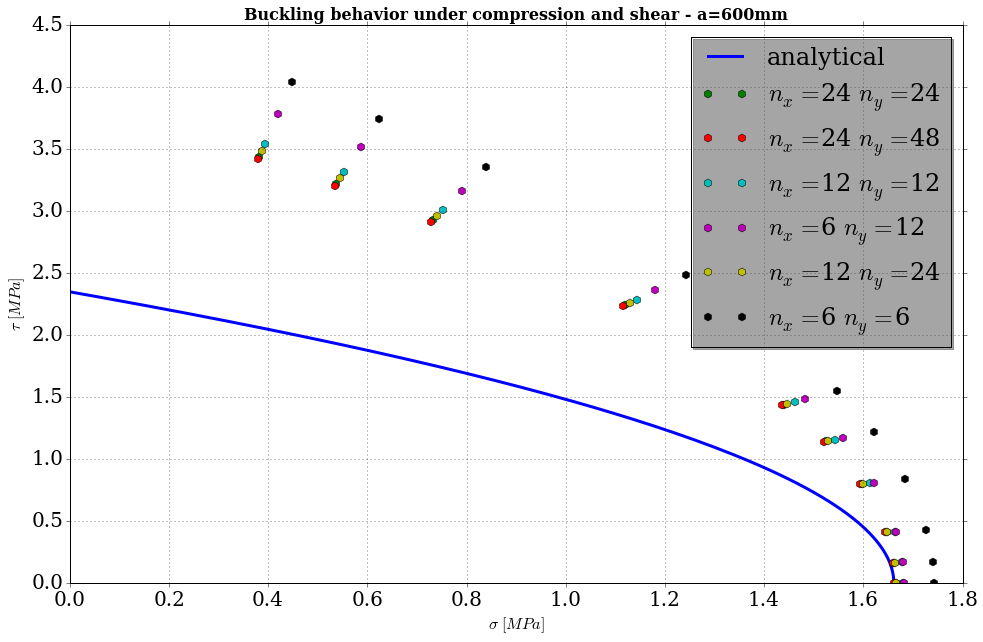

In [95]:
act_a = a_l[0]

plt.figure(figsize=(16,10), dpi=300)
plt.plot(σ, τ,lw=3., label='analytical')

for act_test in cs_eig:
    if int(act_test[1:3])*100 == act_a:
        lb = r'$n_x=$'+str(int(act_test[6:9]))+' $n_y=$'+str(int(act_test[12:15]))
        plt.plot(cs_eig[act_test][0],cs_eig[act_test][1],'h',ms=8,label=lb)

#plt.xlim([0.,4])
#plt.ylim([0.0,1.6])
#plt.xticks(np.arange(0.,4.1,0.5))
#plt.yticks(np.arange(0.0,1.61,.2))
plt.title('Buckling behavior under compression and shear - a='+str(act_a)+'mm', fontsize=16, fontweight='bold')
plt.xlabel(r'$\sigma \ [MPa]$', fontsize=16)
plt.ylabel(r'$\tau \ [MPa]$', fontsize=16)
plt.legend(loc='upper right', shadow=True)
plt.grid()
plt.savefig('Lab08_'+str(act_a)+'.jpg');

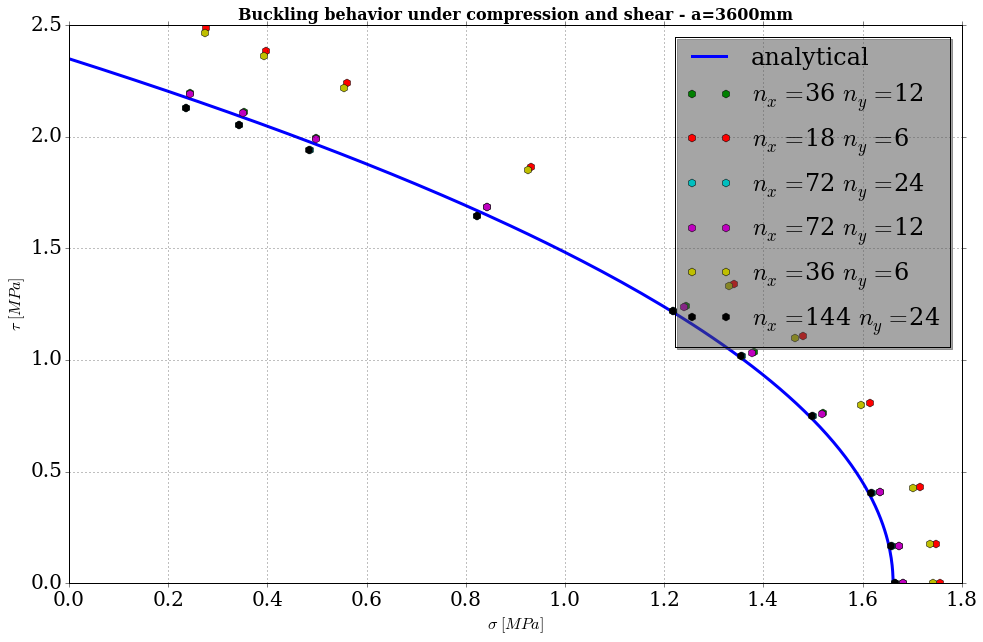

In [96]:
act_a = a_l[1]

plt.figure(figsize=(16,10), dpi=300)
plt.plot(σ, τ,lw=3., label='analytical')

for act_test in cs_eig:
    if int(act_test[1:3])*100 == act_a:
        lb = r'$n_x=$'+str(int(act_test[6:9]))+' $n_y=$'+str(int(act_test[12:15]))
        plt.plot(cs_eig[act_test][0],cs_eig[act_test][1],'h',ms=8,label=lb)

#plt.xlim([0.,4])
#plt.ylim([0.0,1.6])
#plt.xticks(np.arange(0.,4.1,0.5))
#plt.yticks(np.arange(0.0,1.61,.2))
plt.title('Buckling behavior under compression and shear - a='+str(act_a)+'mm', fontsize=16, fontweight='bold')
plt.xlabel(r'$\sigma \ [MPa]$', fontsize=16)
plt.ylabel(r'$\tau \ [MPa]$', fontsize=16)
plt.legend(loc='upper right', shadow=True)
plt.grid()
plt.savefig('Lab08_'+str(act_a)+'.jpg');

#Plot of buckling modes

$\gamma$ values at which we plot the buckled shape:

In [97]:
γ_vect

[0.0, 0.5, 2.0, 6.0]

#Analytical solution

$\gamma = \frac{\tau}{\sigma}$

$\tan \beta = \frac{-1+\sqrt{1+2\gamma^2}}{2\gamma}$

$l = b \cdot \sqrt{1+(\tan \beta)^2}$

$w = \sin \frac{\pi(x-y \tan \beta)}{l} \cdot \cos \frac{\pi y}{b}$

In [98]:
mesh_analytical = {}
z_analytical = {}

for a in a_l:
    x = np.arange(0.0, a*2, 1)
    y = np.arange(0.0, b*2, 1)
    
    z_analytical[a] = {}
    
    mesh_analytical[a] = [x,y]

    xx, yy = np.meshgrid(x, y)
    
    for γ in γ_vect:
        if γ == 0.0:
            tan_β = 0.0
        else:
            tan_β = (-1+np.sqrt(1+2*γ**2))/(2*γ)
        l = b*np.sqrt(1+(tan_β)**2)
        z_analytical[a][γ] = np.sin(np.pi*(xx-yy*tan_β)/l)*np.cos(np.pi*yy/b)

##Plot

In [99]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

lev = np.linspace(-1, 1, 40)

### $\gamma=0.0$ a = 600 mm

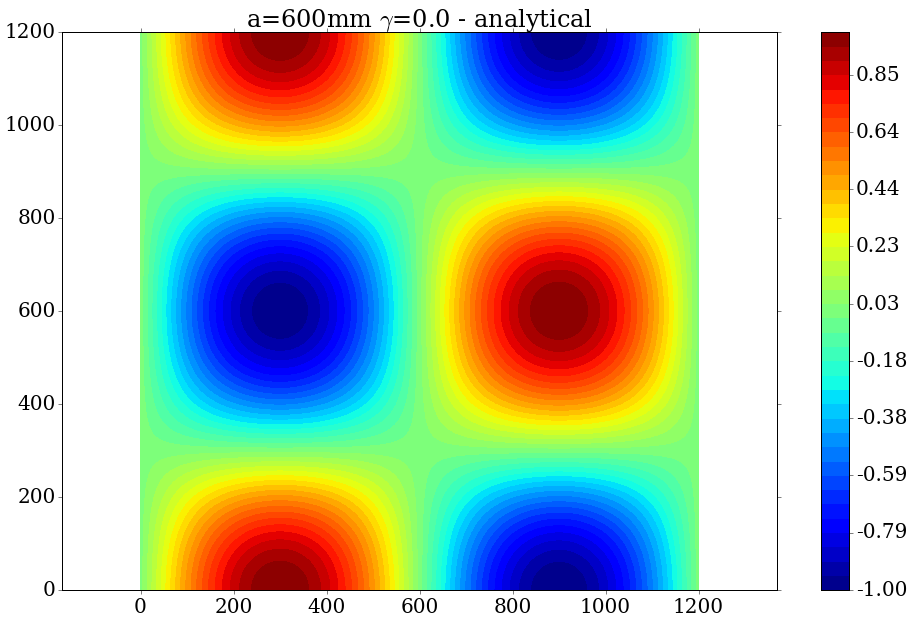

In [100]:
#a = 600
a1 = a_l[0]
#gamma = 0.0
γ1 = γ_vect[0]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

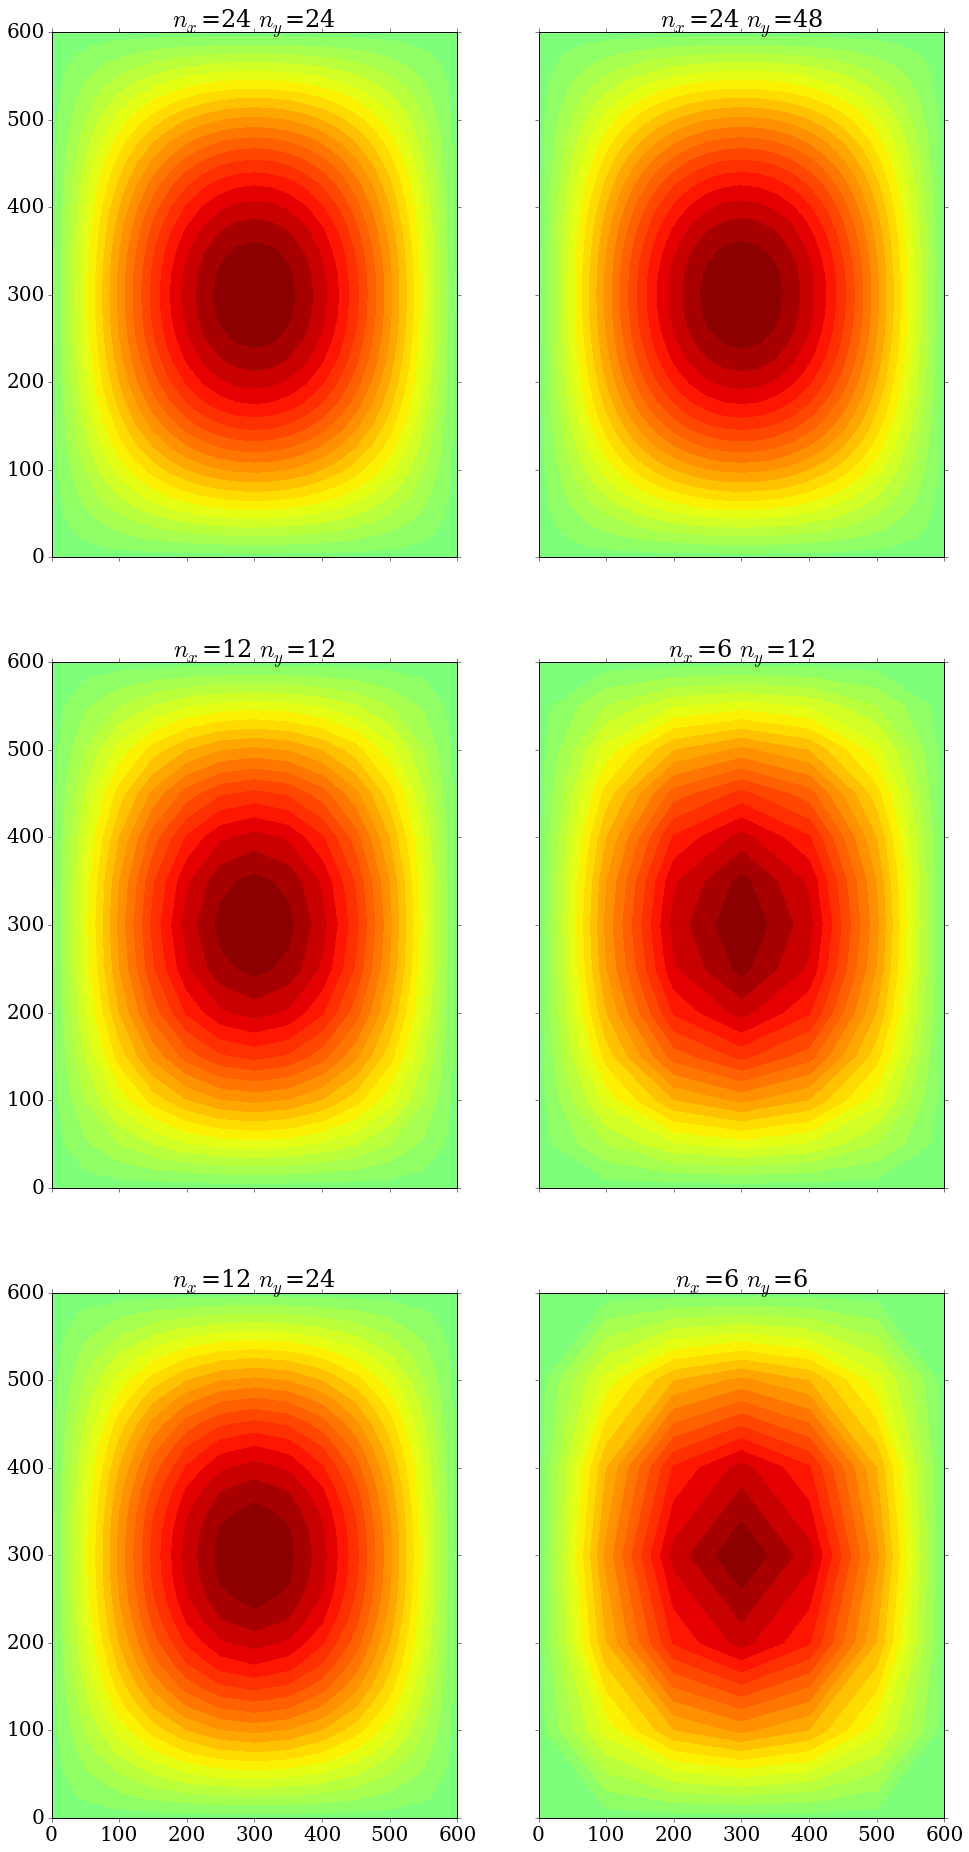

In [101]:
plt.figure(figsize=(16,10), dpi=300)

act_x = 0
act_y = 0

f, ax_arr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a06':
        for act_g in cs_z[act_t]:
            if act_g == 0.0:
                cs = ax_arr[act_x][act_y].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x][act_y].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                if act_y == 0:
                    act_y = 1
                else:
                    act_x = act_x + 1
                    act_y = 0


###γ=0.5 a = 600 mm

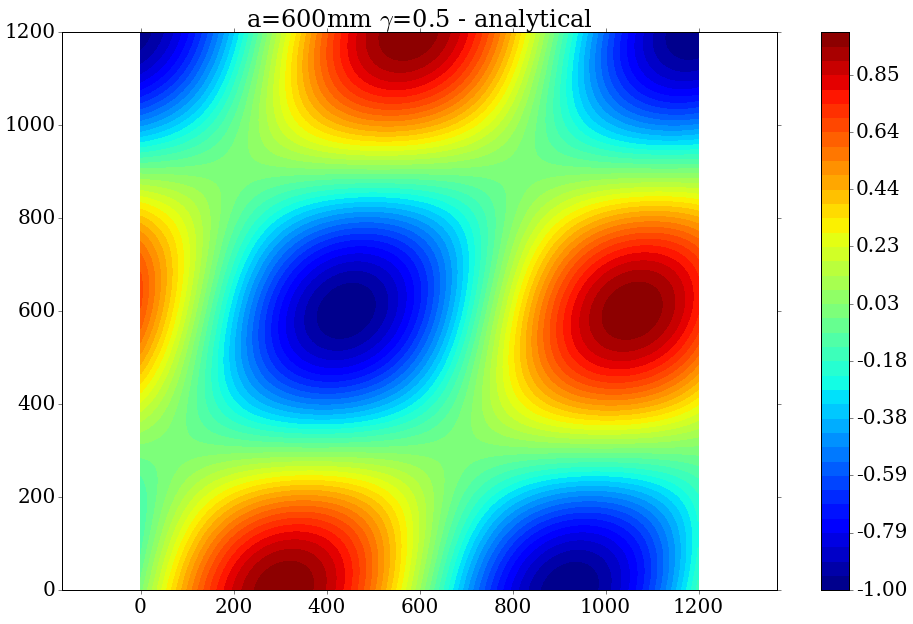

In [102]:
#a = 600
a1 = a_l[0]
#gamma = 0.0
γ1 = γ_vect[1]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

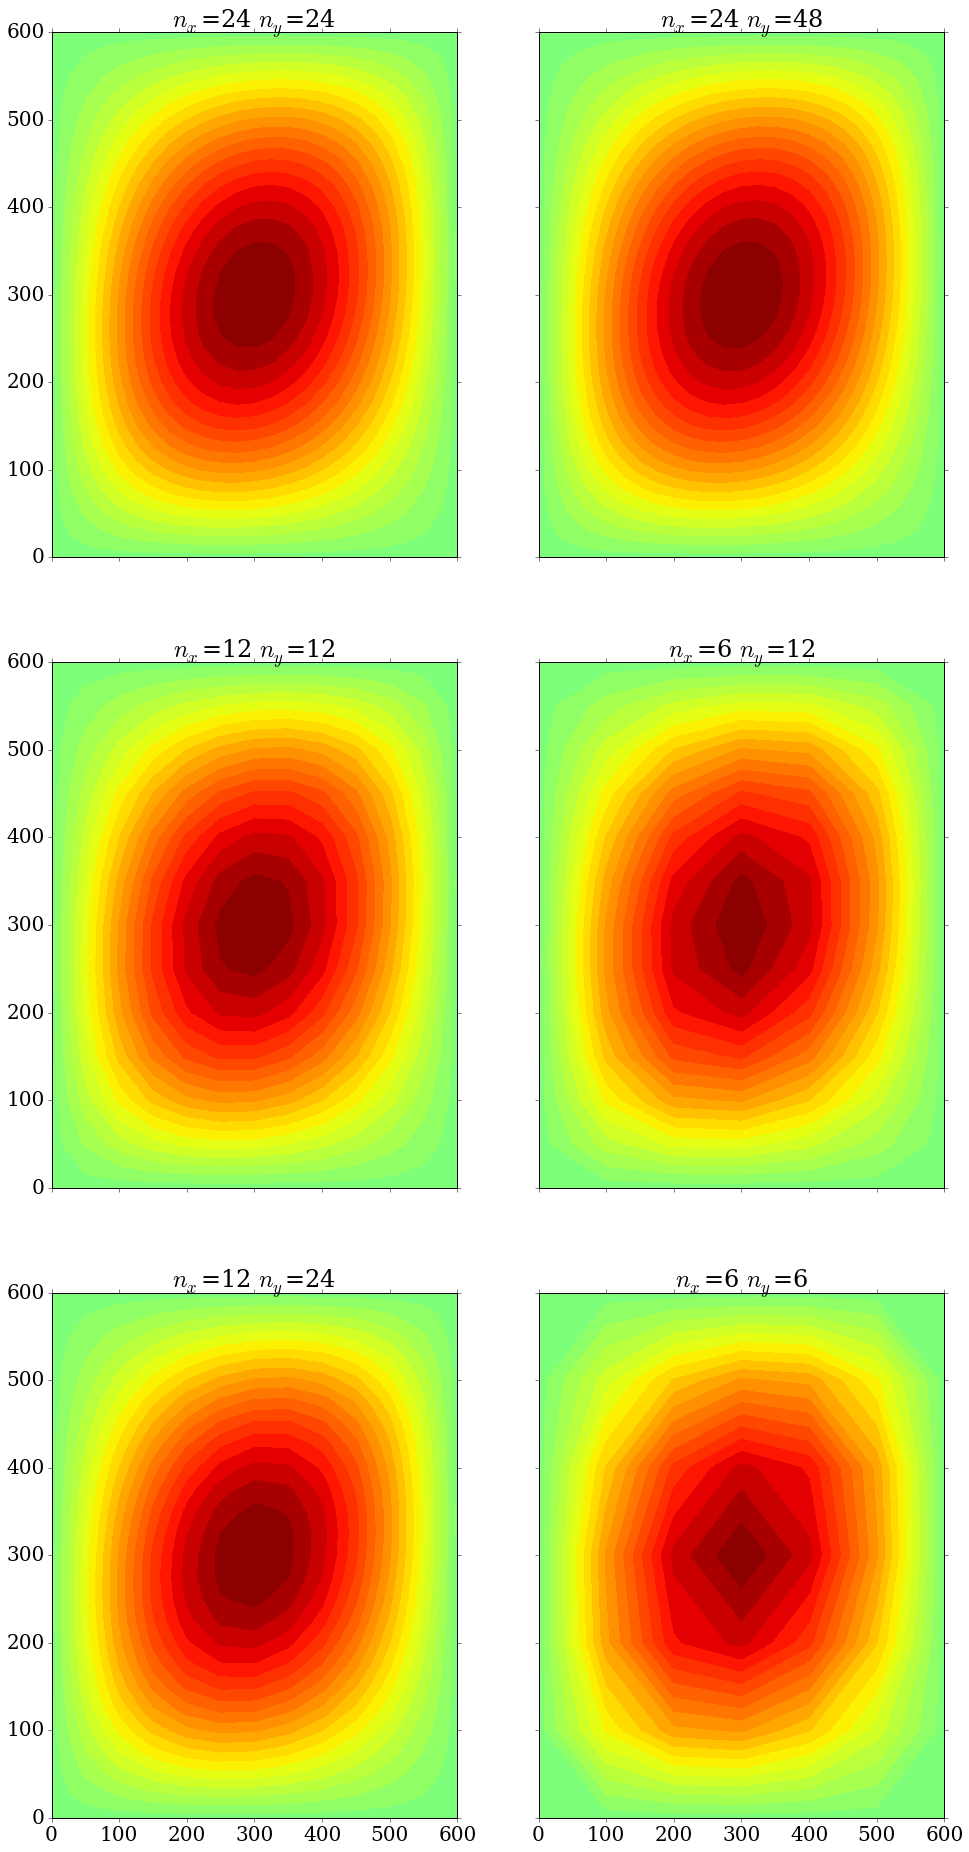

In [103]:
plt.figure(figsize=(16,10), dpi=300)

act_x = 0
act_y = 0

f, ax_arr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a06':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x][act_y].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x][act_y].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                if act_y == 0:
                    act_y = 1
                else:
                    act_x = act_x + 1
                    act_y = 0


###γ=0.5 a = 3600 mm

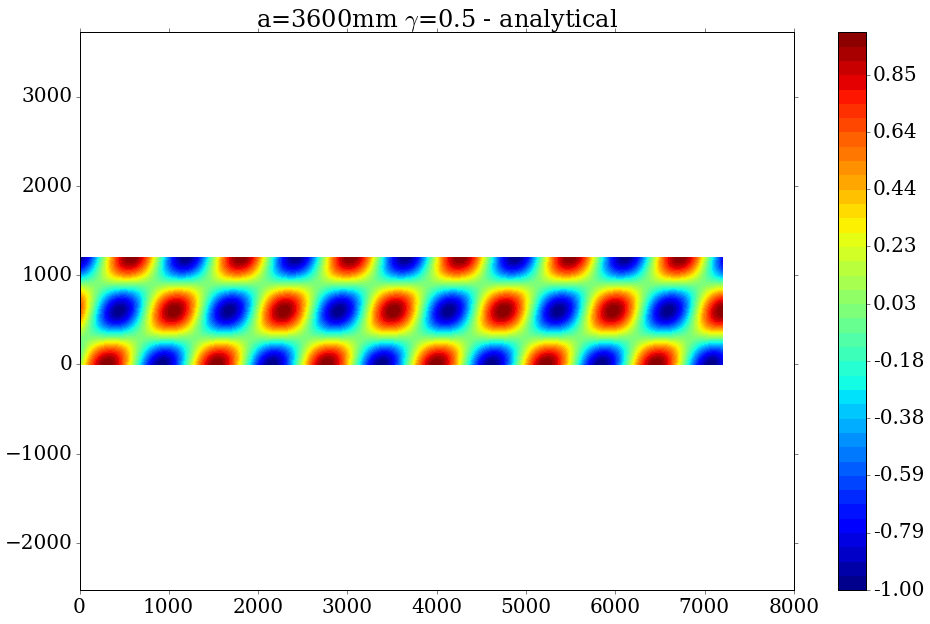

In [104]:
#a = 600
a1 = a_l[1]
#gamma = 0.0
γ1 = γ_vect[1]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

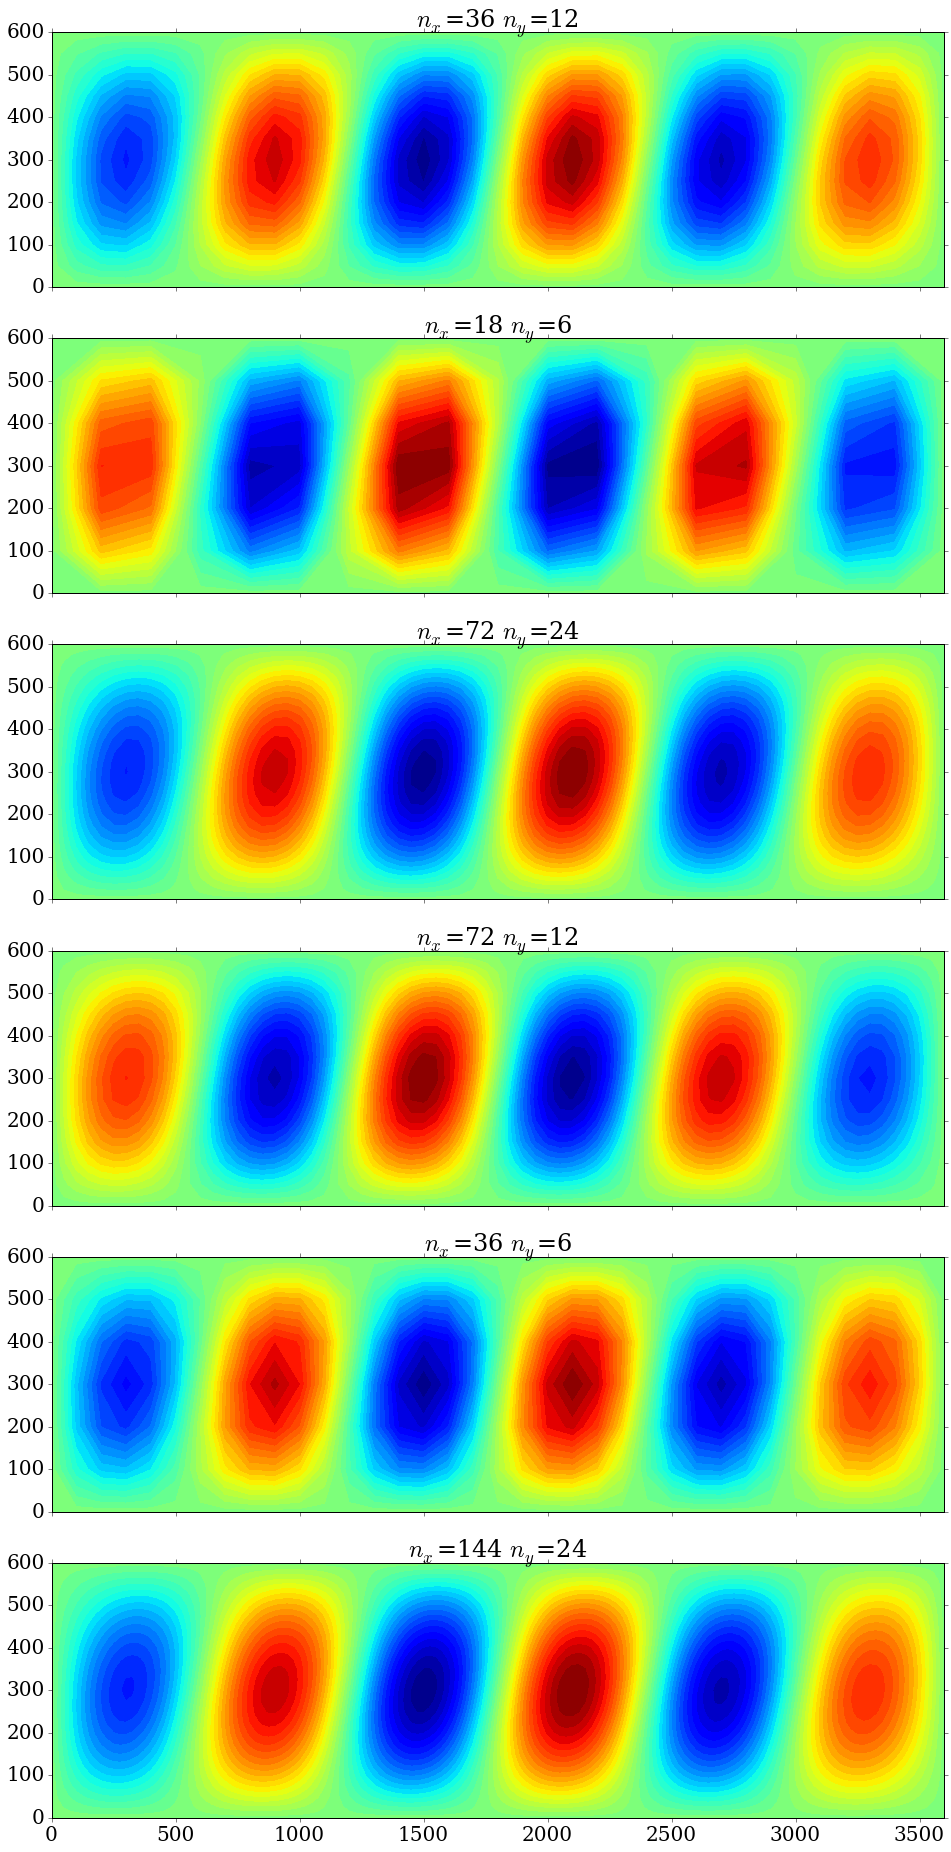

In [105]:
act_x = 0

f, ax_arr = plt.subplots(6, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a36':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                act_x = act_x + 1


###γ=2.0 a = 600 mm

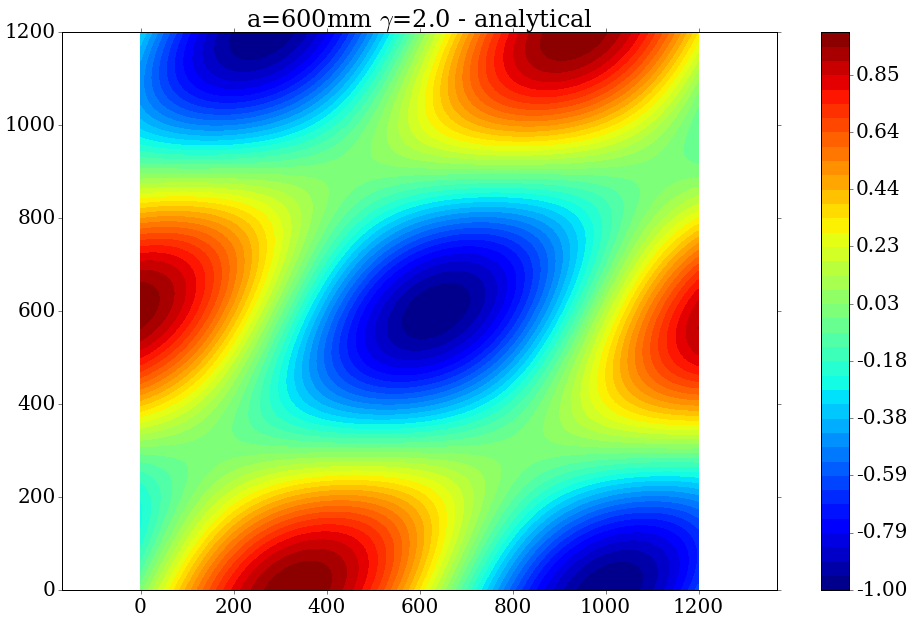

In [106]:
#a = 600
a1 = a_l[0]
#gamma = 2.0
γ1 = γ_vect[2]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

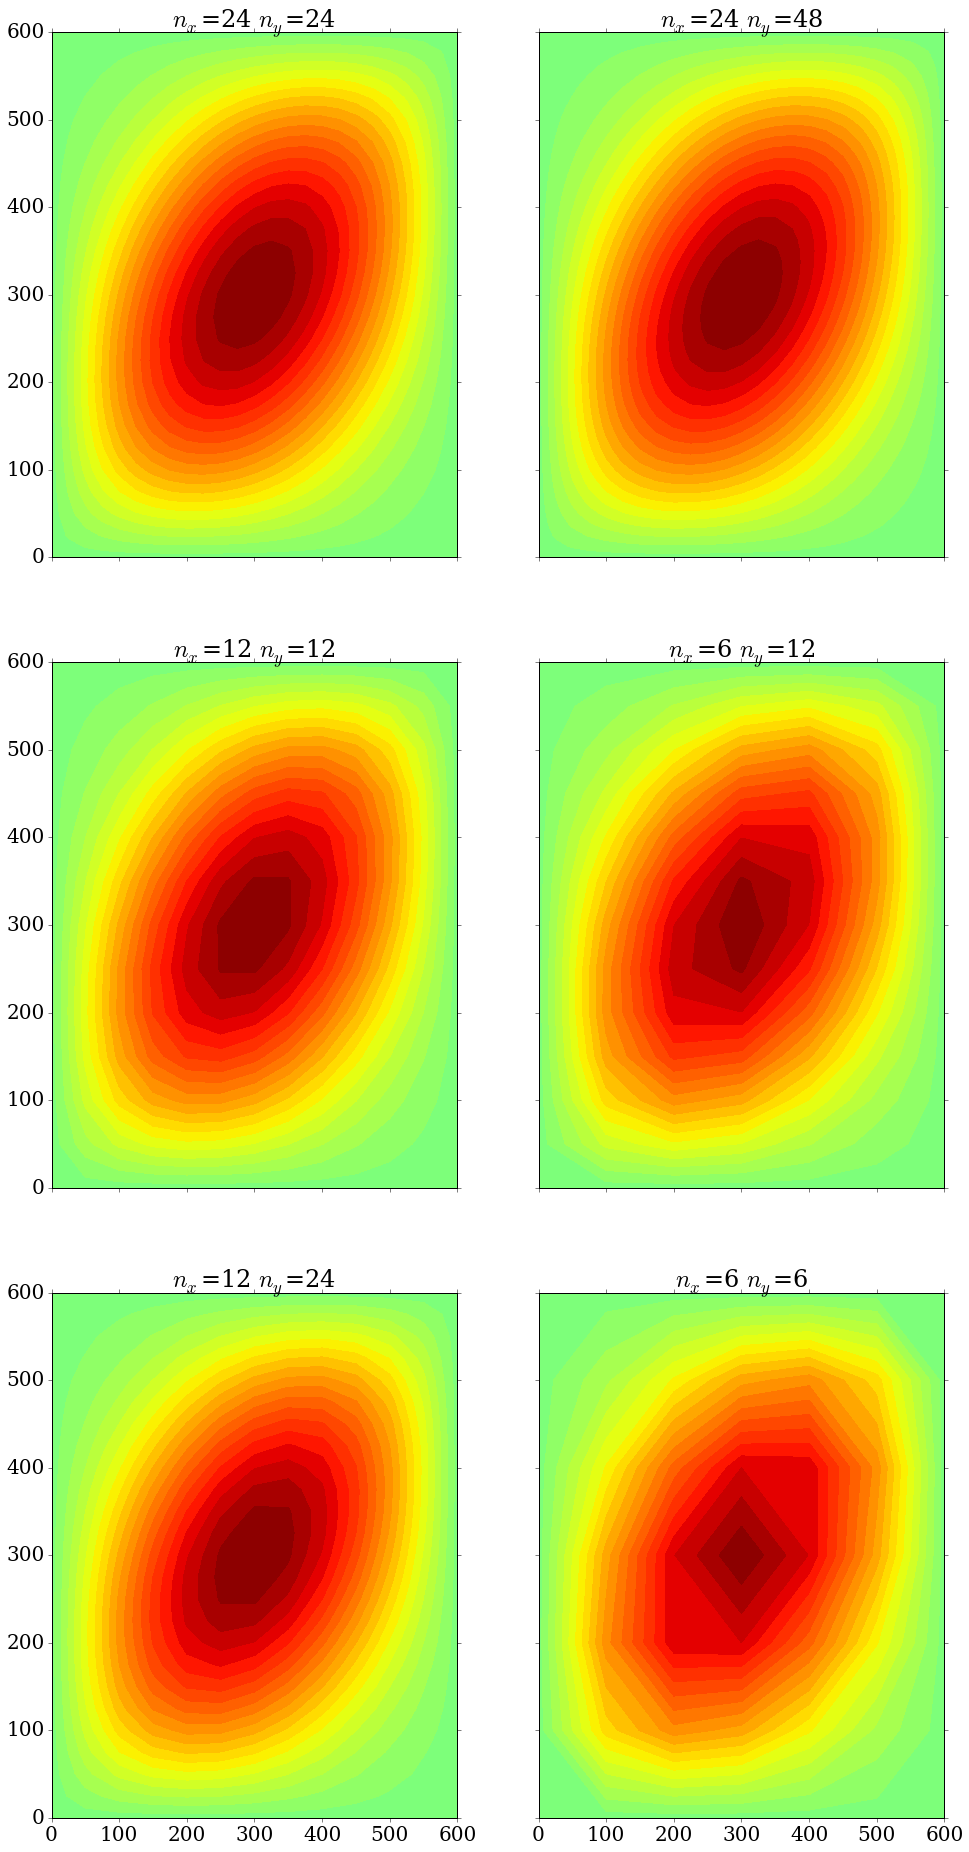

In [107]:
plt.figure(figsize=(16,10), dpi=300)

act_x = 0
act_y = 0

f, ax_arr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a06':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x][act_y].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x][act_y].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                if act_y == 0:
                    act_y = 1
                else:
                    act_x = act_x + 1
                    act_y = 0


###γ=2.0 a = 3600 mm

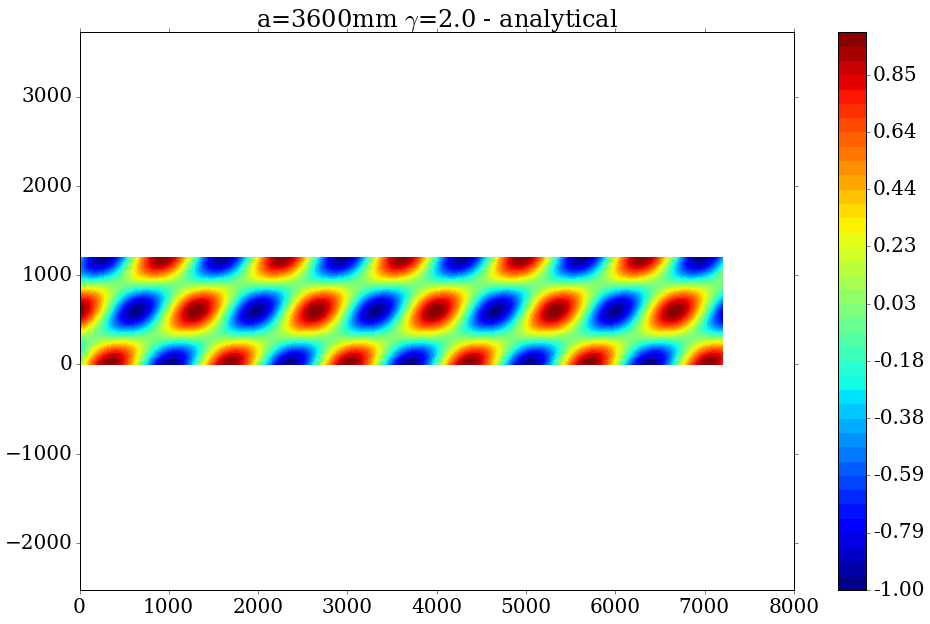

In [108]:
#a = 3600
a1 = a_l[1]
#gamma = 2.0
γ1 = γ_vect[2]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

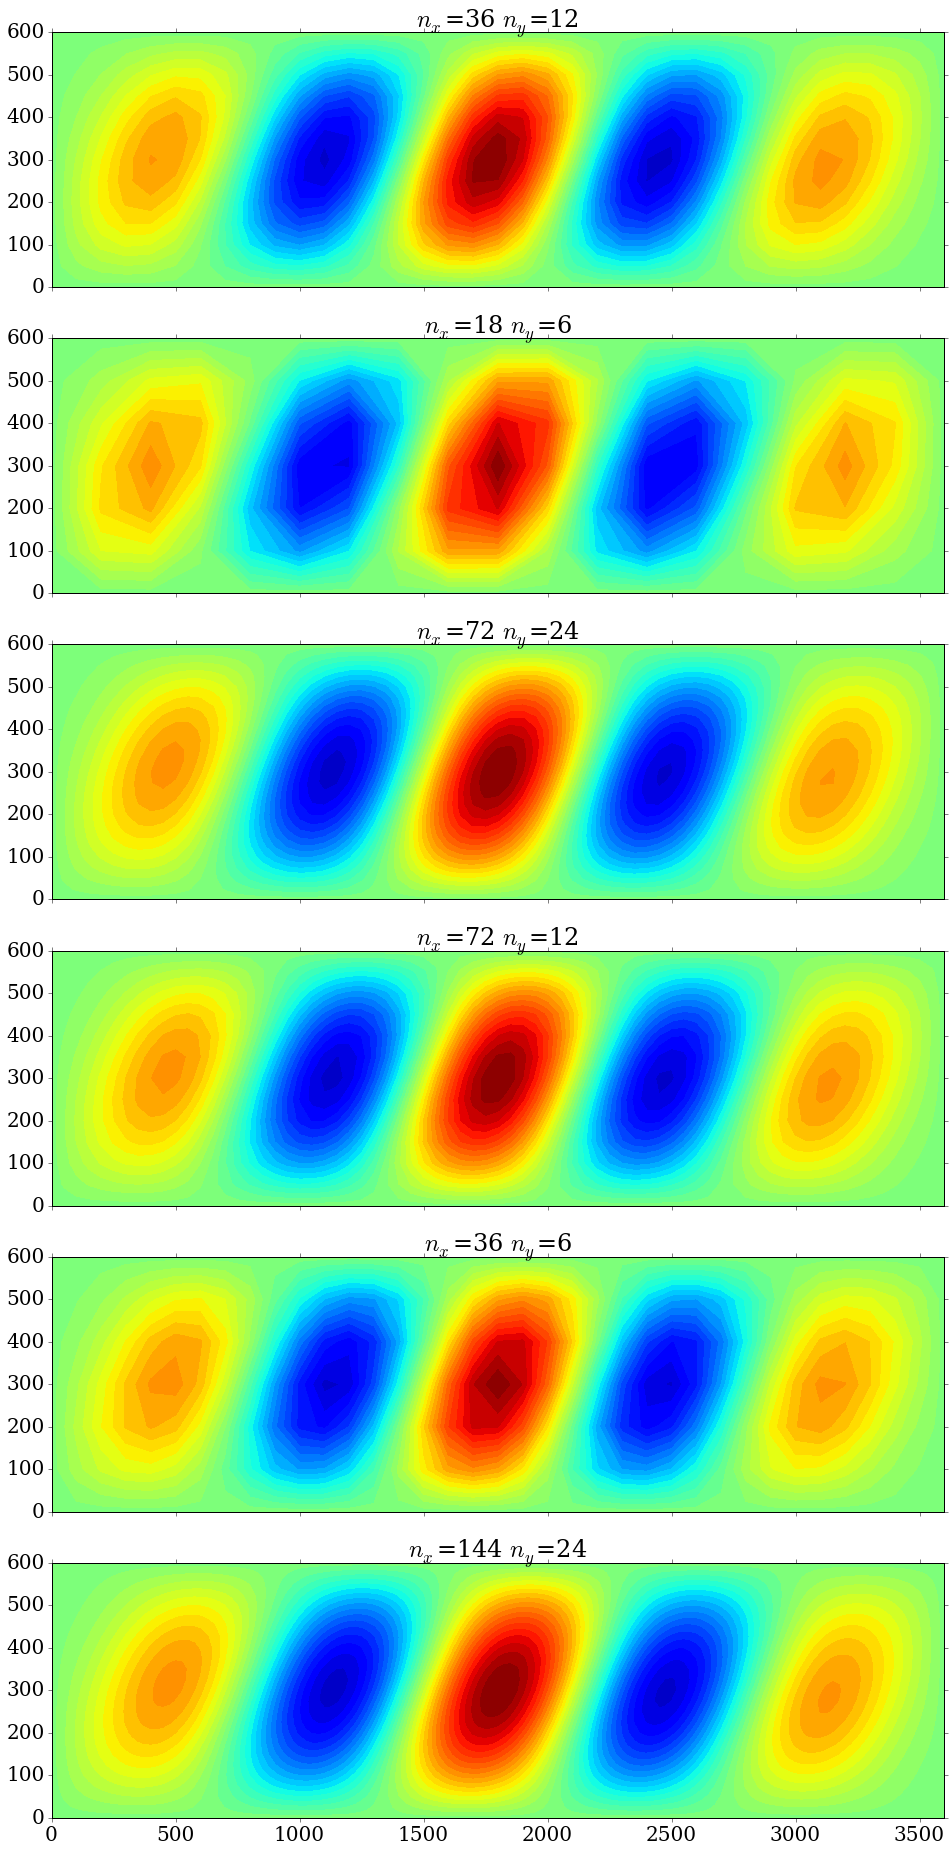

In [109]:
act_x = 0

f, ax_arr = plt.subplots(6, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a36':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                act_x = act_x + 1


###γ=6.0 a = 600 mm

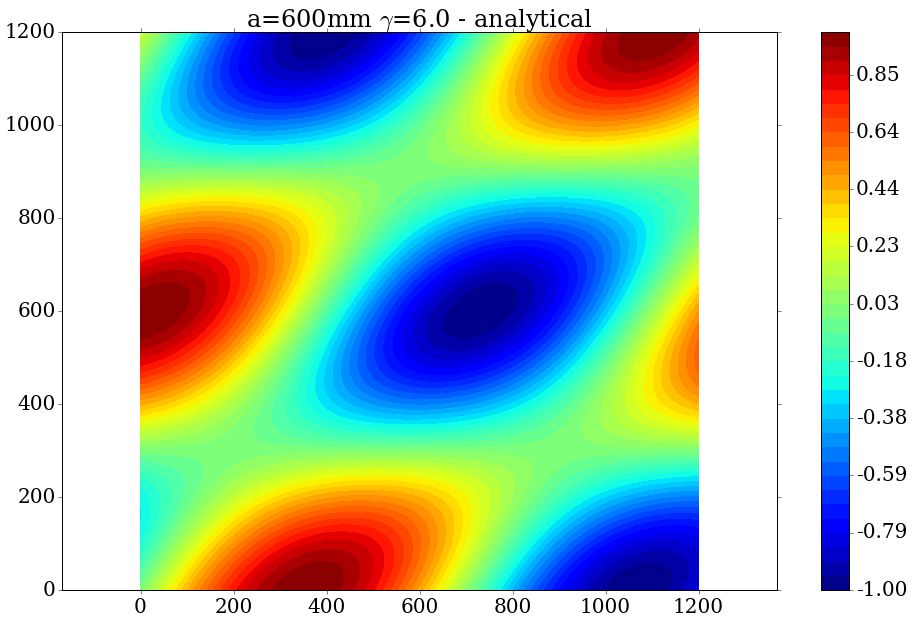

In [110]:
#a = 600
a1 = a_l[0]
#gamma = 0.0
γ1 = γ_vect[3]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

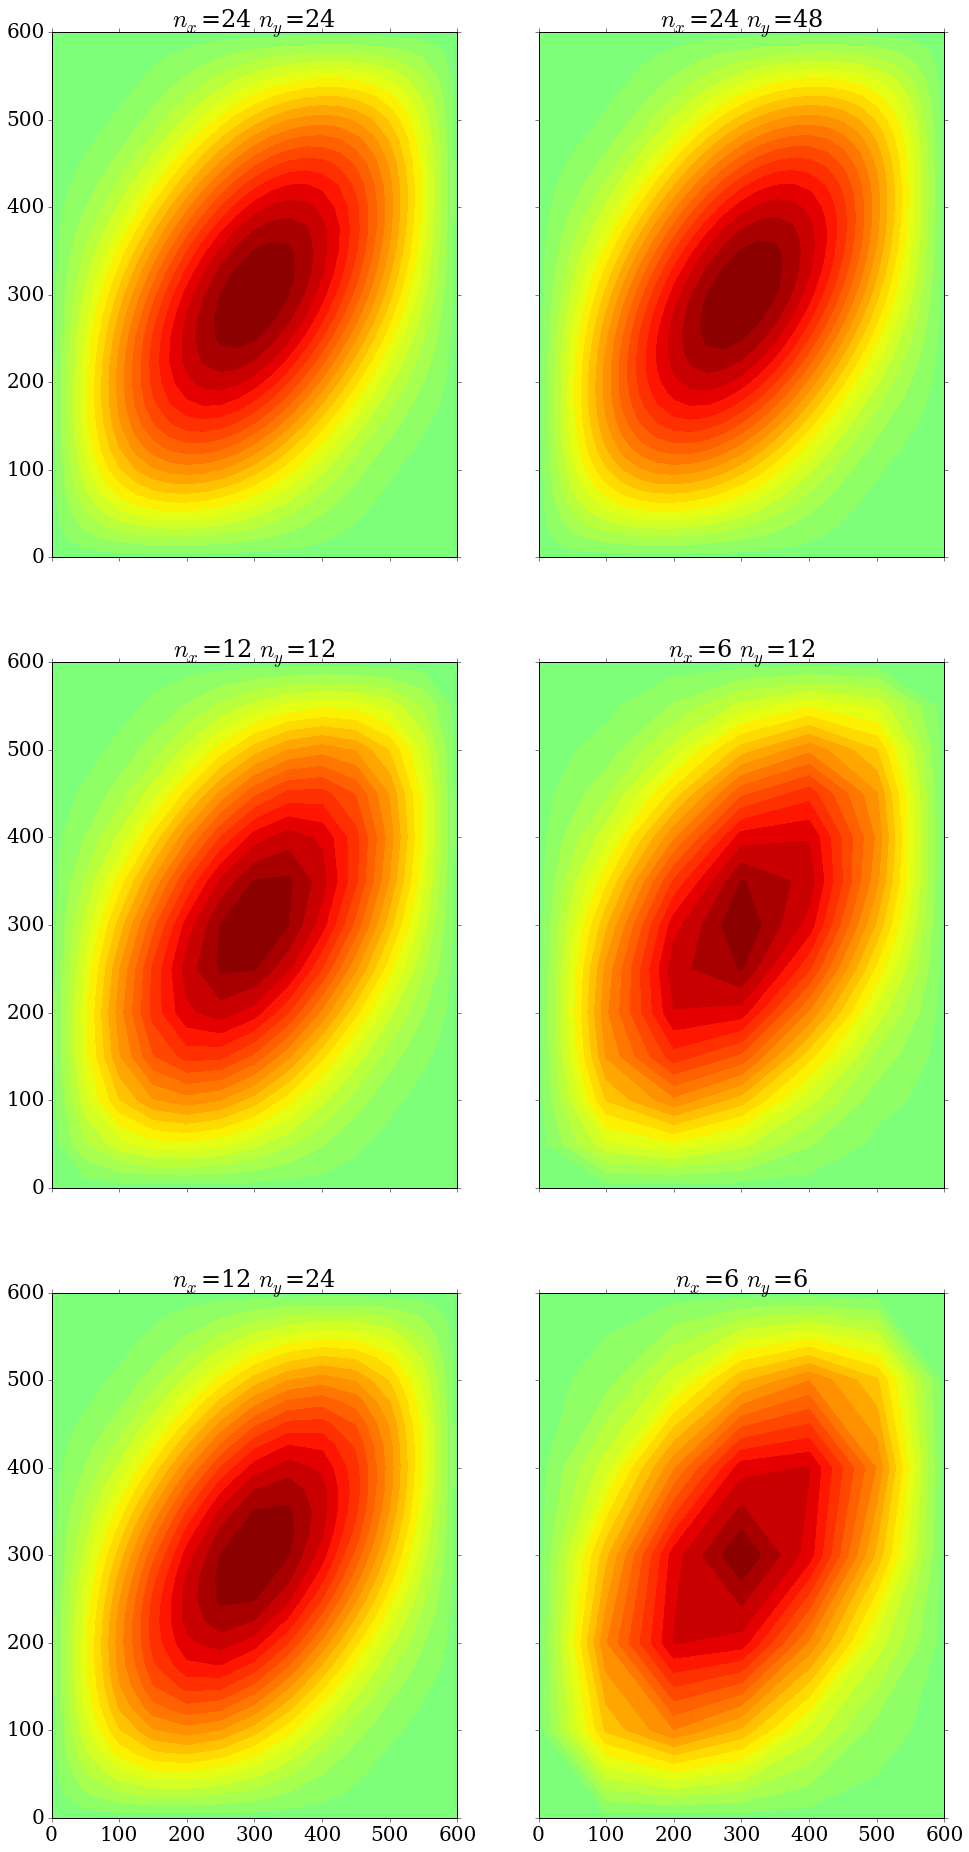

In [111]:
plt.figure(figsize=(16,10), dpi=300)

act_x = 0
act_y = 0

f, ax_arr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a06':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x][act_y].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x][act_y].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                if act_y == 0:
                    act_y = 1
                else:
                    act_x = act_x + 1
                    act_y = 0


###γ=6.0 a = 3600 mm

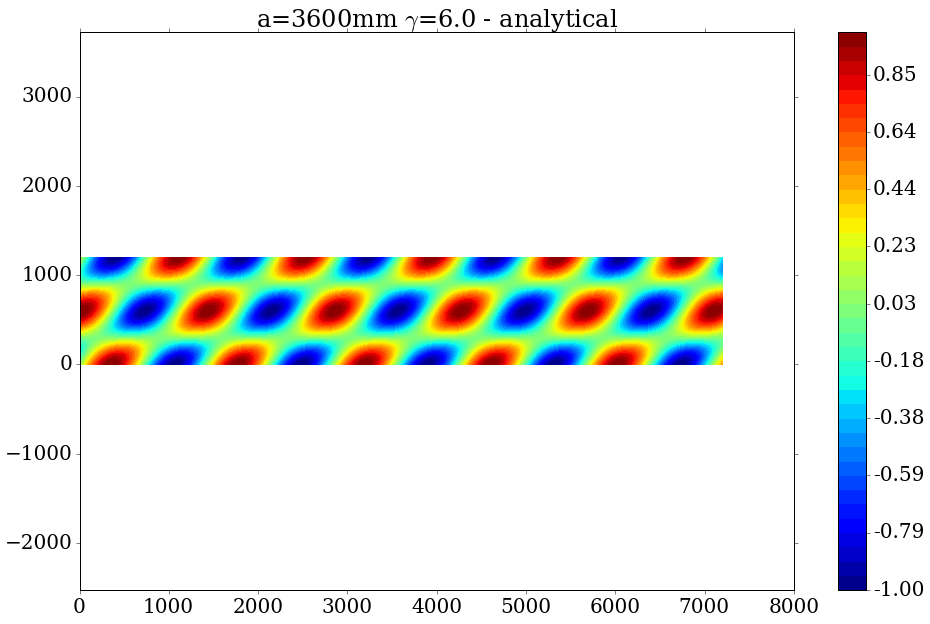

In [112]:
#a = 3600
a1 = a_l[1]
#gamma = 6.0
γ1 = γ_vect[3]

plt.figure(figsize=(16,10), dpi=300)

f1 = plt.contourf(mesh_analytical[a1][0],mesh_analytical[a1][1],z_analytical[a1][γ1],levels= lev)
#plt.clabel(f1, fontsize=9, inline=1);
plt.axis('equal')
plt.title(r'a='+str(a1)+'mm $\gamma$='+str(γ1)+' - analytical')
plt.colorbar(f1, format="%.2f");

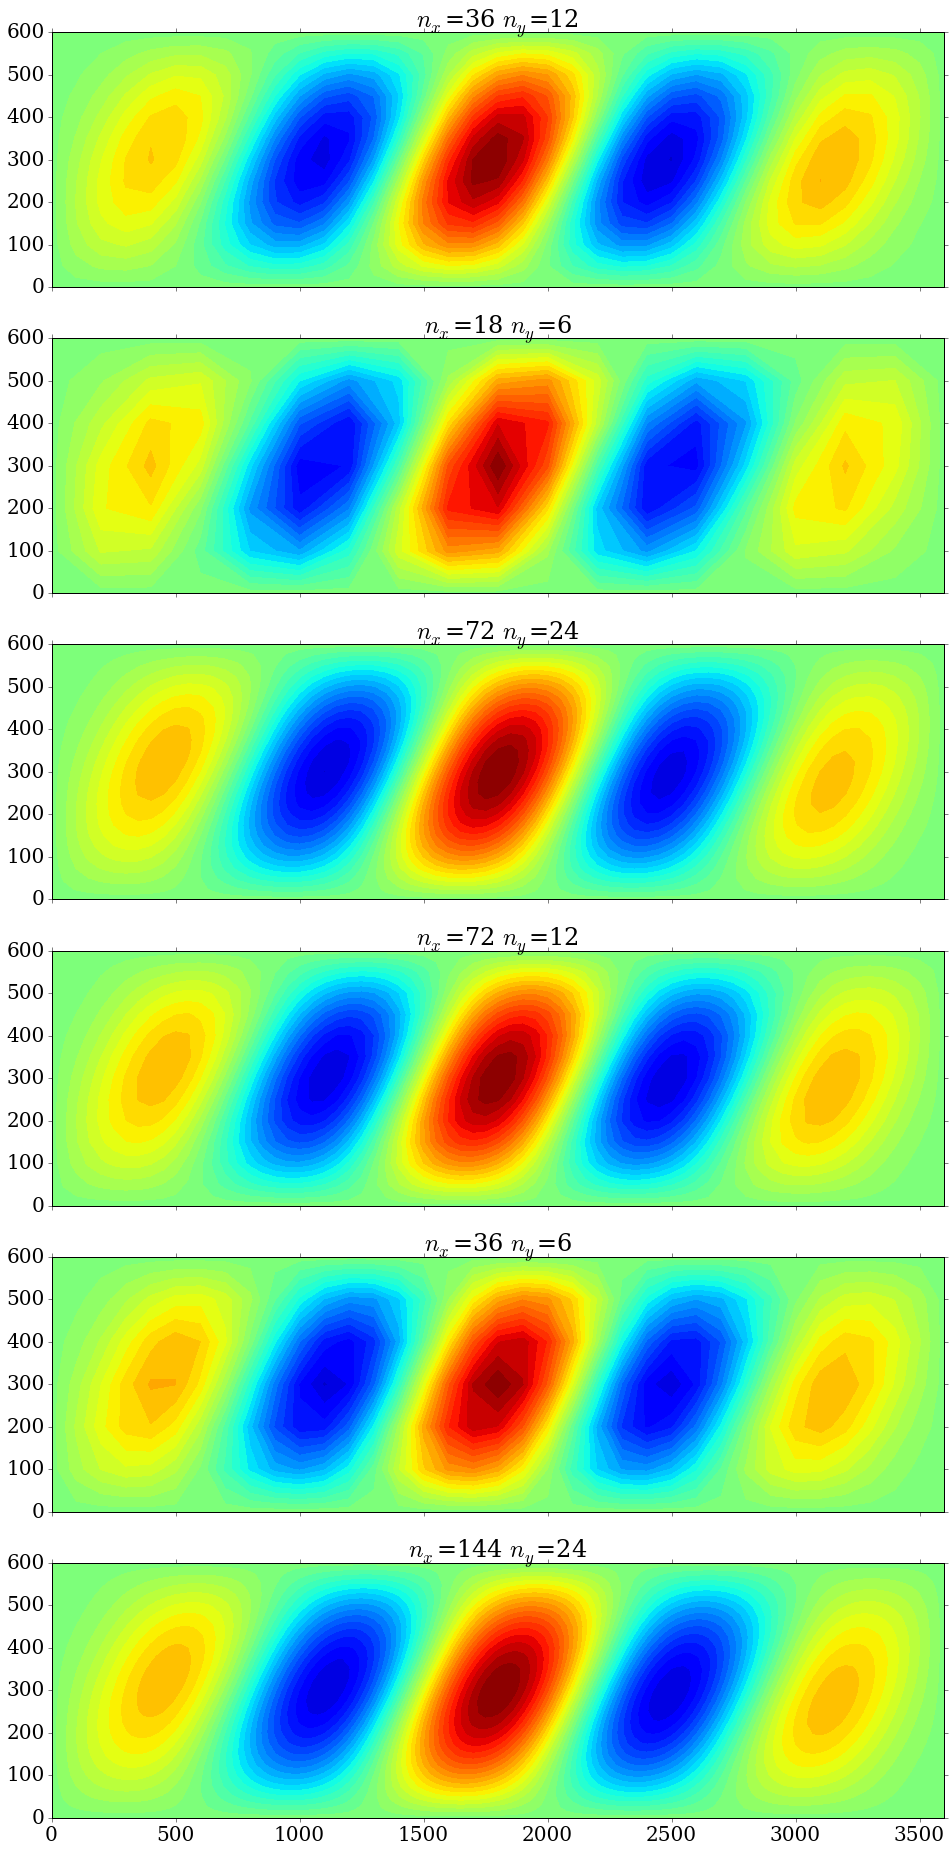

In [113]:
act_x = 0

f, ax_arr = plt.subplots(6, sharex='col', sharey='row', figsize=(16,32));

for act_t in cs_z.keys():
    if act_t[:3] == 'a36':
        for act_g in cs_z[act_t]:
            if act_g == γ1:
                cs = ax_arr[act_x].contourf(cs_z[act_t][act_g][0],cs_z[act_t][act_g][1],\
                                                   cs_z[act_t][act_g][2], levels = lev, aspect='equal');
                ax_arr[act_x].set_title(r'$n_x$='+str(int(act_t[6:9]))+' $n_y$='+str(int(act_t[12:15])));
                act_x = act_x + 1
